# Detecting Pigs and the Swedish Chef based on visual features

This notebook documents our approach to detect occurrences of pigs and of the Swedish chef based on advanced visual feature-engineering.  
We employ a random forst classifier to predict the characters based on different audio-engineering features used for the different characters.

## Time sheet for this notebook

**Daniel Blasko:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>

  </tr>
</thead>
<tbody>
  <tr>
    <td>28.12.2023</td>
    <td>Setup notebook, work on data preparation pipeline</td>
    <td>5</td>
  </tr>
  <tr>
    <td>03.01.2024</td>
    <td>Finish visual data extraction, start experimenting with visual data extraction techniques</td>
    <td>4</td>
  </tr>
  <tr>
    <td>05.01.2024</td>
    <td>Work on visual data extraction techniques</td>
    <td>7</td>
  </tr>
  <tr>
    <td>06.01.2024</td>
    <td>Further work on visual data extraction techniques, prepare classifier</td>
    <td>6</td>
  </tr>
</tbody>
</table>


## Imports


In [ ]:
!pip install -r ../requirements.txt


In [51]:
%load_ext autoreload
%autoreload 2
import os
import json
import matplotlib.pyplot as plt
import librosa.feature as lf
import librosa
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import numpy as np
from skimage.io import imread
from skimage import feature
from tqdm import tqdm


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    accuracy_score,
)


import sys

sys.path.append("..")
from utils.MuppetDataset import MuppetDataset
from utils.visual_evaluation import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_global_confusion_matrix,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the data

Set the booleans below to extract the audio/frames from the .avi files if it has not been done previously. (Need to be true for the first run if you do not have the extracted frames/audios and only the .avi and .csv files).


In [2]:
extract_audio = False
extract_frames = False


In [3]:
video_paths = [
    "../data/Muppets-02-01-01.avi",
    "../data/Muppets-02-04-04.avi",
    "../data/Muppets-03-04-03.avi",
]
annotation_paths = [
    "../data/GroundTruth_Muppets-02-01-01.csv",
    "../data/GroundTruth_Muppets-02-04-04.csv",
    "../data/GroundTruth_Muppets-03-04-03.csv",
]

dataset = MuppetDataset(video_paths, annotation_paths, extract_audio, extract_frames)


Example for handling the data for video 0:

```python
dataset.audio_paths[0]
dataset.audios[0]
dataset.annotations.loc[dataset.annotations.Video == 0]
```


In [4]:
# Sanity check of frame extraction
for i in range(3):
    number_annotated_frames = (
        dataset.annotations.loc[dataset.annotations["Video"] == i].Frame_number.max()
        + 1
    )
    number_extracted_frames = len(
        [
            item
            for item in os.listdir(f"../data/video/{i}")
            if os.path.isfile(os.path.join(f"../data/video/{i}", item))
        ]
    )
    assert number_annotated_frames == number_extracted_frames


At this stage, initially, it was attempted to handle the data similarly to audio: load all extracted frames in a data structure on which the feature extraction methods would be applied. However, this did not turn out to be a viable approach as each video contains ~60 GB of extracted frames that cannot be contained in RAM.  
Thus, in the feature extraction phase that follows, we decided to apply the method frame-by-frame sequentially by loading one frame at a time. This is not ideal, but it is the only way to handle the data without having to resort to a distributed computing approach in our setting. The code for full data loading is still callable from `MuppetDataset.py` if needed.


## Visual feature extraction


### Features for Pigs

The pig characters have quite distinct noses, which we can hopefuly use to detect them. Using the color itself would not be reliable as there are other pink characters. Thus, in an effort to detect snout shapes, we decide to use DAISY descriptors to extract visual region features from the frames.

The DAISY descriptor algorithm transforms local regions of an image into compact, invariant descriptors that we then use for out classification task, based on histograms of gradients. While it is similar to SIFT for example, it differentiates itself by employing gaussian weighting and circularly symmetric kernels. It can both be applied densely across the image or specifically to patches surrounding key points of interest. In our implementation, the descriptor sampling points are spaced at intervals of 180 units. L1 normalization is then applied to each descriptor.


In [48]:
def extract_daisy(
    video_idx,
    frame_path,
    step=170,
    radius=55,
    rings=2,
    histograms=5,
    orientations=6,
    visualize=False,
):
    frame = imread(f"../data/video/{video_idx}/{frame_path}", as_gray=True)
    result = feature.daisy(
        frame,
        step=step,
        radius=radius,
        rings=rings,
        histograms=histograms,
        orientations=orientations,
        visualize=visualize,
    )
    if visualize:
        descriptors, img = result
    else:
        descriptors = result
        img = None
    return descriptors, img


In [54]:
dataset.video_features = {}


for video_idx in dataset.frames.keys():
    for frame_idx, frame_path in tqdm(
        dataset.frames[video_idx],
        desc="Extracting DAISY features for video {}".format(video_idx),
        leave=False,
    ):
        descriptors, _ = extract_daisy(video_idx, frame_path, visualize=False)
        daisy_features = np.reshape(
            descriptors.flatten(), (-1, descriptors.flatten().shape[0])
        )
        # Add extracted features to dataset
        if video_idx not in dataset.video_features:
            dataset.video_features[video_idx] = {}
            dataset.video_features[video_idx]["frames"] = {}
        dataset.video_features[video_idx]["frames"][frame_idx] = {
            "daisy": daisy_features
        }


Extracting DAISY features for video 0:   0%|          | 0/38681 [00:00<?, ?it/s]

In [68]:
import pickle

with open("../results/sim2_visual/daisy.pkl", "wb") as f:
    pickle.dump(dataset.video_features, f)


In [69]:
with open("../results/sim2_visual/daisy.pkl", "rb") as f:
    dataset.video_features = pickle.load(f)


Visualizing the DAISY descriptors for a random frame of the first video:


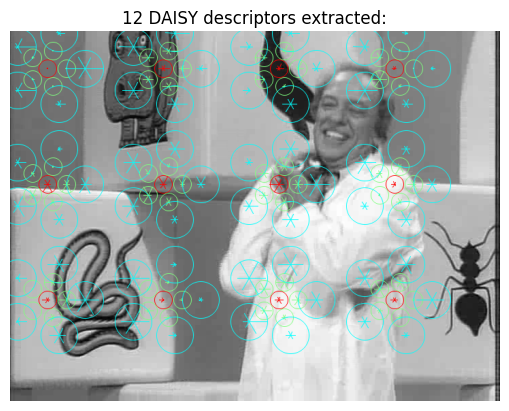

In [46]:
frame_idx = np.random.randint(0, len(dataset.frames[0]))
descriptors, img = extract_daisy(0, dataset.frames[0][frame_idx][1], visualize=True)

fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(img)
descs_num = descriptors.shape[0] * descriptors.shape[1]
ax.set_title("%i DAISY descriptors extracted:" % descs_num)
plt.show()


In this part, we extracted 12 daisy descriptors for each frame (in grayscale, as expected by the feature extractor) and stored those in our dataset as features. The daisy descriptors can be visualized above on a random frame of the first video.  
To obtain a feature vector for a given frame, we flatten the 12 descriptors into a 1D array of length $3 \times 4 \times 66 = 792$.


### Features for the Swedish Chef

As for the Swedish chef, a distinct characteristic of his appearances is his motion patterns where he moves a lot and distinctly.
For that reason, we focus on extracting motion features from the frames. We do that by experimenting with the Lucas-Kanade method and with the Farneback algorithm (Farneback optical flow). Then, at the classification stage, we will experiment with including them both or each one of them exclusively to see which approach performs better.

The Farneback algorithm is a an optical flow technique that computes the motion vector for every pixel in the frame. It estimates the motion between two image frames based on polynomial expansion. By approximating the neighborhoods of each pixel as quadratic, it calculates how these polynomials shift between frames. The Lucas-Kanade method is a sparse optical flow technique that estimates the motion of specific features in the image. It does so by assuming that the motion of these features is constant in a small neighborhood of the pixel. It then estimates the motion of these features by solving a least-squares problem.

The main difference between both approaches is that Farneback provides a motion vector for every pixel (dense), while Lucas-Kanade focuses on specific features (sparse). Thus, the first method is more expensive and leads to a larger feature vector in general, and is more adapted to cases where detailed, pixel-level motion information is needed.


**Extracting Lucas-Kanade features:**


In [108]:
def optical_flow(video_idx, frame_path, previous_frame_path):
    frame = cv2.imread(f"../data/video/{video_idx}/{frame_path}")
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    previous_frame = cv2.imread(f"../data/video/{video_idx}/{previous_frame_path}")
    previous_frame = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)

    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )
    # Detect good features to track
    p0 = cv2.goodFeaturesToTrack(
        previous_frame,
        maxCorners=100,
        qualityLevel=0.3,
        minDistance=7,
        blockSize=7,
        mask=None,
    )
    # Calculate optical flow
    if p0 is None:
        # Handle the case where no features are found
        print(f"No features to track in frame {frame_idx}.")
        return {"displacement": 0, "velocity": 0}

    p1, st, err = cv2.calcOpticalFlowPyrLK(previous_frame, frame, p0, None, **lk_params)
    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # Extracting movement features (displacement between old & new positions, velocity as the rate of change of the object's position)
    features = {}
    diff = good_new - good_old
    features["displacement_norm"] = np.linalg.norm(diff)
    features["velocity_norm"] = features["displacement_norm"] / (1 / dataset.frame_rate)
    features["displacement_mean"] = np.mean(diff)
    features["velocity_mean"] = features["displacement_mean"] / (1 / dataset.frame_rate)
    features["displacement_std"] = np.std(diff)
    features["velocity_std"] = features["displacement_std"] / (1 / dataset.frame_rate)
    features["displacement_max"] = np.max(diff)
    features["velocity_max"] = features["displacement_max"] / (1 / dataset.frame_rate)
    features["displacement_min"] = np.min(diff)
    features["velocity_min"] = features["displacement_min"] / (1 / dataset.frame_rate)

    return features


In [110]:
for video_idx in dataset.frames.keys():
    for frame_idx, frame_path in tqdm(
        dataset.frames[video_idx],
        desc="Extracting Lucas-Kanade flow features for video {}".format(video_idx),
        leave=False,
    ):
        features = optical_flow(
            video_idx,
            frame_path,
            dataset.frames[video_idx][frame_idx - 1][1]
            if frame_idx > 0
            else frame_path,
        )  # for the first frame, we duplicate the frame -> no motion
        # Add extracted features to dataset
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_norm"
        ] = features["displacement_norm"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_norm"
        ] = features["velocity_norm"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_mean"
        ] = features["displacement_mean"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_mean"
        ] = features["velocity_mean"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_std"
        ] = features["displacement_std"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_std"
        ] = features["velocity_std"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_max"
        ] = features["displacement_max"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_max"
        ] = features["velocity_max"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_min"
        ] = features["displacement_min"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_min"
        ] = features["velocity_min"]


{'displacement_norm': 21.771353, 'velocity_norm': 544.2838191986084, 'displacement_mean': -0.11935912, 'velocity_mean': -2.9839780181646347, 'displacement_std': 1.5348328, 'velocity_std': 38.37082087993622, 'displacement_max': 6.0150146, 'velocity_max': 150.3753662109375, 'displacement_min': -2.4238281, 'velocity_min': -60.595703125}


In [ ]:
# Serialization of the extracted features due to long runtime
with open("../results/sim2_visual/daisy_lk.pkl", "wb") as f:
    pickle.dump(dataset.video_features, f)


In [ ]:
with open("../results/sim2_visual/daisy_lk.pkl", "rb") as f:
    dataset.video_features = pickle.load(f)


**Extracting Farneback optical flow features:**


In [115]:
def farneback_optical_flow(video_idx, frame_path, previous_frame_path):
    frame = cv2.imread(f"../data/video/{video_idx}/{frame_path}")
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    previous_frame = cv2.imread(f"../data/video/{video_idx}/{previous_frame_path}")
    previous_frame = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(
        previous_frame, frame, None, 0.5, 3, 15, 3, 5, 1.2, 0
    )
    # At this stage, the flow vector is a 2d array.
    # For each pixel [i, j], flow[i, j] gives the displacement vector [Δx, Δy] representing the motion of that pixel between the two frames.

    # We reduce noise by applying a Gaussian blur to the flow vector.
    # This is done by convolving the flow vector with a Gaussian kernel.
    flow_blurred = cv2.GaussianBlur(flow, (5, 5), 0)
    # Then we perform thresholding to remove low displacement values (most probably noise).
    magnitude, angle = cv2.cartToPolar(flow_blurred[..., 0], flow_blurred[..., 1])
    # Create a mask where the magnitude is greater than the threshold
    magnitude_mask = magnitude > 2.0
    flow_thresholded = np.zeros_like(flow_blurred)
    flow_thresholded[magnitude_mask] = flow_blurred[magnitude_mask]

    # Finally, we create aggregated statistics for the flow vector that will be our features
    mean_flow = np.mean(flow_thresholded, axis=(0, 1))
    std_flow = np.std(flow_thresholded, axis=(0, 1))
    # Histograms of flow orientations & magnitudes
    num_bins = 8
    hist_angle = np.histogram(angle, bins=num_bins, range=(0, 2 * np.pi))[0]
    hist_magnitude = np.histogram(magnitude, bins=num_bins)[0]

    # Dividing frame into a grid and extracting features for each cell
    grid_size = 8
    h, w = flow.shape[:2]
    cell_h, cell_w = h // grid_size, w // grid_size

    grid_features = []
    for i in range(0, h, cell_h):
        for j in range(0, w, cell_w):
            cell_flow = flow[i : i + cell_h, j : j + cell_w]
            cell_mean = np.mean(cell_flow, axis=(0, 1))
            grid_features.append(cell_mean)

    features = {
        "mean_flow": mean_flow,
        "std_flow": std_flow,
        "hist_angle": hist_angle,
        "hist_magnitude": hist_magnitude,
        "grid_features": grid_features,
    }
    return features


In [118]:
for video_idx in dataset.frames.keys():
    for frame_idx, frame_path in tqdm(
        dataset.frames[video_idx],
        desc="Extracting farneback flow features for video {}".format(video_idx),
        leave=False,
    ):
        features = farneback_optical_flow(
            video_idx,
            frame_path,
            dataset.frames[video_idx][frame_idx - 1][1]
            if frame_idx > 0
            else frame_path,
        )  # for the first frame, we duplicate the frame -> no motion
        # Add extracted features to dataset
        # TODO: could np.concat feature vector...
        dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_mean_flow"
        ] = features["mean_flow"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_std_flow"
        ] = features["std_flow"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_hist_angle"
        ] = features["hist_angle"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_hist_magnitude"
        ] = features["hist_magnitude"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_grid_features"
        ] = features["grid_features"]


Extracting farneback flow features for video 0:   0%|          | 0/38681 [00:00<?, ?it/s]

{'mean_flow': array([-0.00911216,  0.00084872], dtype=float32), 'std_flow': array([0.19633304, 0.15760781], dtype=float32), 'hist_angle': array([43497, 23636, 34022, 56146, 67568, 63337, 50095, 53379]), 'hist_magnitude': array([149697, 172496,  64788,   3913,    417,    181,    144,     44]), 'grid_features': [array([-0.89166594, -0.8779296 ], dtype=float32), array([-0.5378205 , -0.54126817], dtype=float32), array([-0.307185 , -0.4841239], dtype=float32), array([-0.38048095, -1.0073123 ], dtype=float32), array([-0.05108089, -1.088637  ], dtype=float32), array([ 0.18882792, -0.33467123], dtype=float32), array([ 0.38745952, -0.4596394 ], dtype=float32), array([ 0.59857464, -0.64137375], dtype=float32), array([-1.0544546, -0.7807481], dtype=float32), array([-0.98797286, -0.75333667], dtype=float32), array([-0.5667621, -0.7601212], dtype=float32), array([-0.24181491, -0.5771456 ], dtype=float32), array([-0.13872522, -0.5808979 ], dtype=float32), array([ 0.36152104, -0.6824032 ], dtype=floa

In [ ]:
# Serialization of the extracted features due to long runtime
with open("../results/sim2_visual/daisy_lk_fb.pkl", "wb") as f:
    pickle.dump(dataset.video_features, f)


In [ ]:
with open("../results/sim2_visual/daisy_lk_fb.pkl", "rb") as f:
    dataset.video_features = pickle.load(f)


### Merge into the dataframe that will be used for model training & prepare the model dataset

We merge all extracted features into a single dataframe.


In [130]:
counter = 0
video_features = pd.DataFrame()
for video_idx in range(3):
    for frame_idx in tqdm(
        range(len(dataset.video_features[video_idx]["frames"])),
        desc=f"Extracting features for video {video_idx}",
    ):
        daisy = dataset.video_features[video_idx]["frames"][frame_idx]["daisy"]
        # lk_displacement = dataset.video_features[video_idx]["frames"][frame_idx][
        #     "lk_displacement"
        # ]
        # lk_velocity = dataset.video_features[video_idx]["frames"][frame_idx][
        #     "lk_velocity"
        # ]
        # fb_mean_flow = dataset.video_features[video_idx]["frames"][frame_idx][
        #     "fb_mean_flow"
        # ]
        # fb_std_flow = dataset.video_features[video_idx]["frames"][frame_idx][
        #     "fb_std_flow"
        # ]
        # fb_hist_angle = dataset.video_features[video_idx]["frames"][frame_idx][
        #     "fb_hist_angle"
        # ]
        # fb_hist_magnitude = dataset.video_features[video_idx]["frames"][frame_idx][
        #     "fb_hist_magnitude"
        # ]
        # fb_grid_features = dataset.video_features[video_idx]["frames"][frame_idx][
        #     "fb_grid_features"
        # ]

        frame_features = {
            "video_idx": video_idx,
            "frame_idx": frame_idx,
            **{"daisy_" + str(i): val for i, val in enumerate(daisy[0])},
            # **{
            #     "lk_displacement_" + str(i): val
            #     for i, val in enumerate(lk_displacement)
            # },
            # **{"lk_velocity_" + str(i): val for i, val in enumerate(lk_velocity)},
            # **{"fb_mean_flow_" + str(i): val for i, val in enumerate(fb_mean_flow)},
            # **{"fb_std_flow_" + str(i): val for i, val in enumerate(fb_std_flow)},
            # **{"fb_hist_angle_" + str(i): val for i, val in enumerate(fb_hist_angle)},
            # **{
            #     "fb_hist_magnitude_" + str(i): val
            #     for i, val in enumerate(fb_hist_magnitude)
            # },
            # **{
            #     "fb_grid_features_" + str(i): val
            #     for i, val in enumerate(fb_grid_features)
            # },
        }

        video_features = pd.concat(
            [video_features, pd.DataFrame(frame_features, index=[counter])],
            ignore_index=True,
        )
        counter += 1

# Add annotations
video_features = video_features.merge(
    dataset.annotations[["Video", "Frame_number", "Pigs", "Cook"]],
    how="left",
    left_on=["video_idx", "frame_idx"],
    right_on=["Video", "Frame_number"],
)
video_features = video_features.drop(columns=["Frame_number", "Video"])


Extracting features for video 2: 100%|██████████| 38498/38498 [1:04:34<00:00,  9.94it/s]


In [131]:
video_features.to_csv("../results/sim2_visual/daisy_lucas-kanade_farneback.csv")


In [132]:
video_features.shape


(115885, 796)

Sanity check:


In [133]:
assert dataset.annotations.shape[0] == video_features.shape[0]
assert dataset.annotations["Pigs"].sum() == video_features["Pigs"].sum()
np.testing.assert_array_equal(
    dataset.annotations["Pigs"].values, video_features["Pigs"].values
)
np.testing.assert_array_equal(
    dataset.annotations["Cook"].values,
    video_features["Cook"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Video"].values,
    video_features["video_idx"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Frame_number"].values,
    video_features["frame_idx"].values,
)


In [134]:
video_features.sample(10)


,video_idx,frame_idx,daisy_0,daisy_1,daisy_2,daisy_3,daisy_4,daisy_5,daisy_6,daisy_7,...,daisy_784,daisy_785,daisy_786,daisy_787,daisy_788,daisy_789,daisy_790,daisy_791,Pigs,Cook
13314,0,13314,0.005805,0.005227,0.011009,0.017013,0.007251,0.004140,0.002616,0.002684,...,0.020268,0.016598,0.021041,0.019726,0.015502,0.013951,0.016413,0.019165,0,0
58088,1,19407,0.001717,0.001168,0.001258,0.002464,0.004071,0.003662,0.001146,0.000916,...,0.012520,0.012566,0.011028,0.013602,0.012923,0.011436,0.011893,0.011595,0,0
13389,0,13389,0.014052,0.008876,0.017100,0.028870,0.011887,0.008781,0.002214,0.002373,...,0.002954,0.004114,0.018636,0.012567,0.011653,0.017658,0.014074,0.013650,0,0
23425,0,23425,0.012804,0.021263,0.015362,0.007698,0.005144,0.005682,0.013111,0.020417,...,0.018756,0.021032,0.029568,0.023678,0.025909,0.027381,0.022701,0.024105,0,0
110843,2,33456,0.010433,0.014175,0.013633,0.008873,0.011627,0.011765,0.025045,0.019007,...,0.016938,0.014631,0.019793,0.013463,0.013107,0.022025,0.013761,0.012192,1,0
95450,2,18063,0.017854,0.012525,0.011536,0.017904,0.014390,0.015510,0.010945,0.006004,...,0.014890,0.013134,0.014036,0.016074,0.015280,0.013887,0.015611,0.014926,1,0
32174,0,32174,0.005630,0.015417,0.018130,0.013050,0.013923,0.010188,0.008258,0.020812,...,0.017937,0.017591,0.012282,0.009945,0.008427,0.010200,0.010539,0.012344,0,0
22694,0,22694,0.005781,0.009406,0.009831,0.008599,0.019692,0.017341,0.007812,0.010379,...,0.017804,0.017959,0.014099,0.016864,0.017554,0.014714,0.016136,0.017344,0,0
35870,0,35870,0.018095,0.018913,0.020968,0.022534,0.012664,0.010705,0.008961,0.017856,...,0.024281,0.022254,0.015356,0.021801,0.020550,0.014845,0.020627,0.020692,0,0
5363,0,5363,0.005056,0.001824,0.001480,0.004089,0.010296,0.010554,0.005912,0.002456,...,0.016218,0.012912,0.011233,0.010845,0.010822,0.013746,0.011855,0.010389,0,0


In [135]:
video_features.describe()


,video_idx,frame_idx,daisy_0,daisy_1,daisy_2,daisy_3,daisy_4,daisy_5,daisy_6,daisy_7,...,daisy_784,daisy_785,daisy_786,daisy_787,daisy_788,daisy_789,daisy_790,daisy_791,Pigs,Cook
count,115885.000000,115885.000000,1.158850e+05,1.158850e+05,1.158850e+05,1.158850e+05,1.158850e+05,1.158850e+05,1.158850e+05,1.158850e+05,...,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000
mean,0.998421,19313.777952,1.068304e-02,1.013311e-02,1.033687e-02,1.191105e-02,1.176136e-02,1.104058e-02,1.080637e-02,1.056926e-02,...,0.017681,0.017282,0.014109,0.015049,0.014222,0.013951,0.014698,0.014277,0.185356,0.029728
std,0.816088,11151.279978,7.783094e-03,6.442540e-03,6.281983e-03,7.686735e-03,6.962839e-03,6.917617e-03,8.068956e-03,7.162475e-03,...,0.008663,0.008632,0.006793,0.008547,0.007745,0.007194,0.007815,0.007235,0.388588,0.169836
min,0.000000,0.000000,2.085598e-08,2.085598e-08,2.085598e-08,2.085598e-08,2.085598e-08,2.085598e-08,4.060539e-08,4.060539e-08,...,0.000050,0.000050,0.000018,0.000033,0.000029,0.000016,0.000036,0.000036,0.000000,0.000000
25%,0.000000,9657.000000,4.796774e-03,4.829900e-03,5.353153e-03,6.608745e-03,6.390424e-03,5.620405e-03,4.899096e-03,5.072721e-03,...,0.012413,0.011926,0.009987,0.010051,0.009543,0.009611,0.009983,0.009934,0.000000,0.000000
50%,1.000000,19314.000000,9.563252e-03,9.403566e-03,9.208235e-03,1.075136e-02,1.085466e-02,9.891039e-03,9.533631e-03,9.186902e-03,...,0.016203,0.015709,0.012988,0.013890,0.013081,0.012886,0.013695,0.013382,0.000000,0.000000
75%,2.000000,28971.000000,1.485998e-02,1.428662e-02,1.438812e-02,1.537599e-02,1.588491e-02,1.527079e-02,1.461787e-02,1.546292e-02,...,0.020779,0.020361,0.017247,0.018214,0.017534,0.017070,0.017861,0.017325,0.000000,0.000000
max,2.000000,38705.000000,8.279600e-02,6.309712e-02,5.772268e-02,8.329849e-02,5.750292e-02,5.283140e-02,8.294338e-02,1.025069e-01,...,0.134864,0.120535,0.136389,0.195120,0.139319,0.167813,0.170137,0.142015,1.000000,1.000000


We extract the `X` and `y` matrices for the model:


In [136]:
# We extract the `X` and `y` matrices for the model, and then split into train and test sets by a 80/20 ratio
X = video_features.drop(columns=["Pigs", "Cook", "video_idx", "frame_idx"])
y = video_features[["Pigs", "Cook"]]


And then split into train and test sets by a 80/20 ratio.
However, we do not use a shuffled random split like one would often use in tabular-data machine learning: this would lead to test-set contamination, as neighboring frames are highly correlated, and we would have such neighboring frames in both the train and test sets.  
However, to observe the difference in results, we implemented both the random and non-random approaches and tried out both.

Due to this reasoning, we decide to use the first 80% of the ordered frames as training data and the last 20% as testing data.


In [137]:
RANDOM_SPLIT = True  # Change this boolean to experiment with one option or another


In [138]:
if RANDOM_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.head(int(X.shape[0] * 0.8))
    X_test = X.tail(int(X.shape[0] * 0.2))
    y_train = y.head(int(y.shape[0] * 0.8))
    y_test = y.tail(int(y.shape[0] * 0.2))

assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]


## Training the vision-based model


For this task, we decide to use a random forest classifier.
Right now, the `y` matrix one-hot encodes the labels, but we need to convert it to a single column of labels for the classifier, where:

- 0: neither pigs nor the Swedish chef are present
- 1: Pigs are present
- 2: The Swedish chef is present
- 3: both are present


In [140]:
y_train = np.argmax(y_train, axis=1) + np.any(y_train, axis=1)
y_test = np.argmax(y_test, axis=1) + np.any(y_test, axis=1)


def convert_predictions_to_one_hot(predictions):
    y_pred_one_hot = np.zeros((predictions.size, y_train.shape[1]))
    y_pred_one_hot[
        np.arange(predictions.size), predictions - np.any(y_train, axis=1)
    ] = 1


**Training the random forest classifier while determining the best hyperparameter combination through grid search:**


In [141]:
param_grid = {
    # "max_depth": [3, 5, 10, None],
    # "n_estimators": [10, 100, 200],
    # "max_features": [1, 3, 5, 7],
    # "min_samples_leaf": [1, 2, 3],
    # "min_samples_split": [1, 2, 3],
}
grid_search = GridSearchCV(
    RandomForestClassifier(), param_grid, cv=3, scoring="recall_weighted"
)  # We optimize for recall because in experiments, false negatives were the biggest problem
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print(grid_search.best_params_)
y_pred = best_rf.predict(X_test)


{}


## Evaluating the model


In [142]:
# Convert labels for the first character
y_test_pigs = (y_test == 1) | (y_test == 3)
y_pred_pigs = (y_pred == 1) | (y_pred == 3)

# Convert labels for the second character
y_test_cook = (y_test == 2) | (y_test == 3)
y_pred_cook = (y_pred == 2) | (y_pred == 3)


# Compute metrics for the first character
accuracy_pigs = accuracy_score(y_test_pigs, y_pred_pigs)
precision_pigs = precision_score(y_test_pigs, y_pred_pigs)
recall_pigs = recall_score(y_test_pigs, y_pred_pigs)
f1_pigs = f1_score(y_test_pigs, y_pred_pigs)
map_pigs = average_precision_score(y_test_pigs, y_pred_pigs)

# Compute metrics for the second character
accuracy_cook = accuracy_score(y_test_cook, y_pred_cook)
precision_cook = precision_score(y_test_cook, y_pred_cook)
recall_cook = recall_score(y_test_cook, y_pred_cook)
f1_cook = f1_score(y_test_cook, y_pred_cook)
map_cook = average_precision_score(y_test_cook, y_pred_cook)

# Compute metrics for the general classifier as a whole
accuracy_general = accuracy_score(y_test, y_pred)
precision_general = precision_score(y_test, y_pred, average="weighted")
recall_general = recall_score(y_test, y_pred, average="weighted")
f1_general = f1_score(y_test, y_pred, average="weighted")


***General model metrics***
	Accuracy: 0.9909392932648746
	Precision: 0.990984679449878
	Recall: 0.9909392932648746
	F1: 0.990880554423247
***Pigs***
	Accuracy: 0.991802217715839
	Precision: 0.9952301454805629
	Recall: 0.9608565507713562
	F1: 0.9777413308341143
	MAP: 0.9636082626433253
***Swedish chef***
	Accuracy: 0.9990939293264874
	Precision: 1.0
	Recall: 0.9662379421221865
	F1: 0.9828291087489779
	MAP: 0.9671440127956991


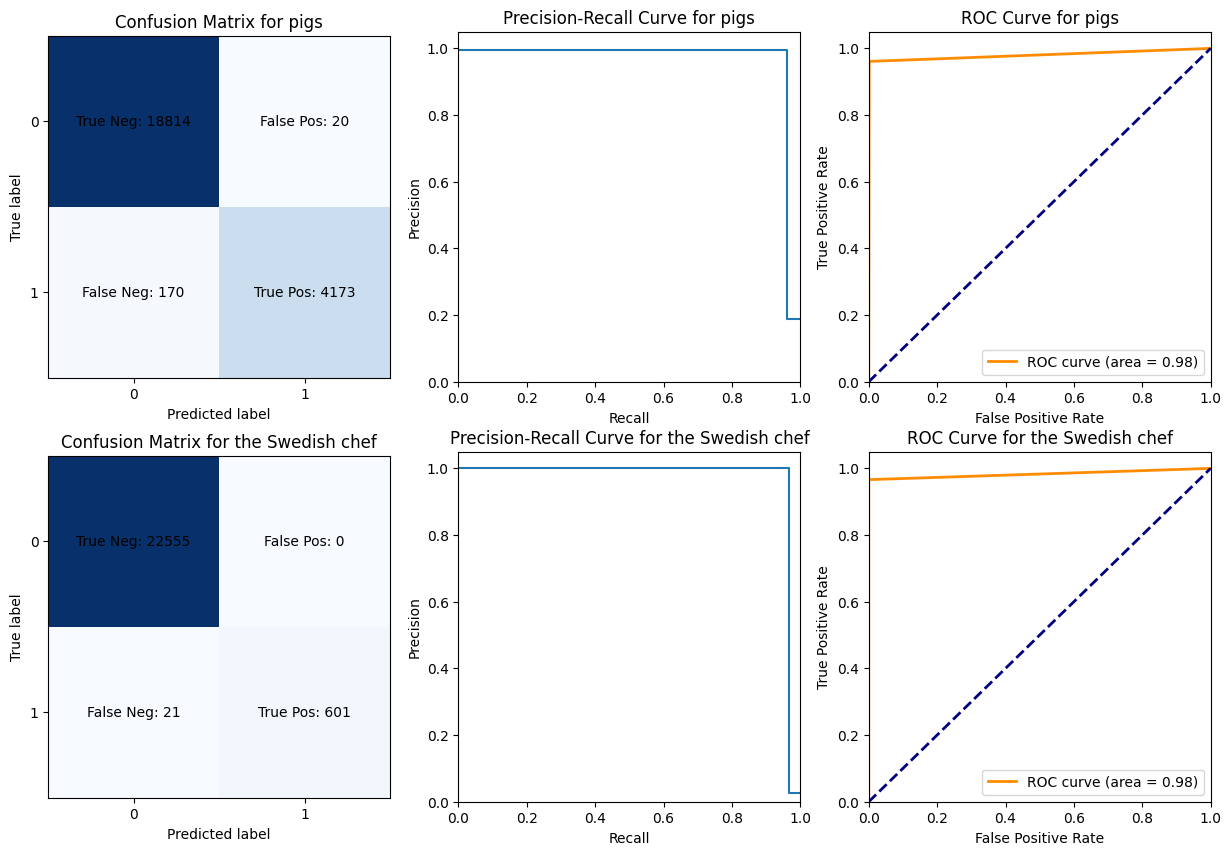

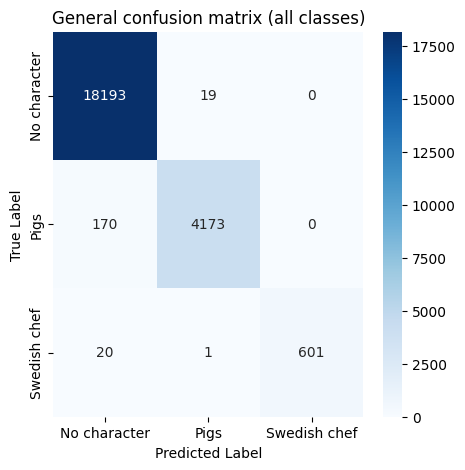

In [143]:
# *** Metrics ***
print(
    f"***General model metrics***\n\tAccuracy: {accuracy_general}\n\tPrecision: {precision_general}\n\tRecall: {recall_general}\n\tF1: {f1_general}"
)
print(
    f"***Pigs***\n\tAccuracy: {accuracy_pigs}\n\tPrecision: {precision_pigs}\n\tRecall: {recall_pigs}\n\tF1: {f1_pigs}\n\tMAP: {map_pigs}"
)
print(
    f"***Swedish chef***\n\tAccuracy: {accuracy_cook}\n\tPrecision: {precision_cook}\n\tRecall: {recall_cook}\n\tF1: {f1_cook}\n\tMAP: {map_cook}"
)

# *** Visual evaluation ***
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# Pigs
plot_confusion_matrix(
    y_test_pigs, y_pred_pigs, "Confusion Matrix for pigs", ax=axs[0, 0]
)
plot_precision_recall_curve(
    y_test_pigs, y_pred_pigs, "Precision-Recall Curve for pigs", ax=axs[0, 1]
)
plot_roc_curve(y_test_pigs, y_pred_pigs, "ROC Curve for pigs", ax=axs[0, 2])
# Swedish chef
plot_confusion_matrix(
    y_test_cook,
    y_pred_cook,
    "Confusion Matrix for the Swedish chef",
    ax=axs[1, 0],
)
plot_precision_recall_curve(
    y_test_cook,
    y_pred_cook,
    "Precision-Recall Curve for the Swedish chef",
    ax=axs[1, 1],
)
plot_roc_curve(y_test_cook, y_pred_cook, "ROC Curve for the Swedish chef", ax=axs[1, 2])
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plot_global_confusion_matrix(
    y_test,
    y_pred,
    "Pigs",
    "Swedish chef",
)


### Result discussion, observations and other things we tried to improve performance

The performance of the model has been evaluated under three angles:

- Kermit classification (_metrics/plots for success at classifying frames where the Kermit flag is true_). **_Reminder_**: as stated previously, for Kermit, there are no "audio-only" annotations, there might be undetected true positives/true negatives in the Kermit classification as the model might predict the absence of Kermit due to him not making sounds in the frame, but he might be present in the video making the label 1.
- Waldorf & Statler classification (_metrics/plots for success at classifying frames where the Waldorf & Statler audio flag is true_).
- Overall classification performance (_metrics/plots for the general multi-class classification task - weighted performance metrics have been employed_).

The best performing model uses the following features (_explanations on why we chose them for characteristics of the characters are given in the feature extraction part of the notebook_):

- Loudness (through RMS energy).
- Zero-crossing rate.
- 19 MFCCs to describe the timbre/the short-term power spectrum of the sound.

All these features are fed, as a vector of values, into a k-nearest-neighbors classifier. All parameters are normalized, to make sure they are all of equal importance in the distance metric that the classifier uses by constraining them to the same order of magnitude. The number of neighbors considered, as well as the distance metric, are selected based on 5-fold cross-validation on the training dataset.  
This way, the best performing model, with the features described above, achieves the following performance metrics (we report them for both the random and non-random split of the dataset described in the data splitting part of the notebook):

**Performance with the random split:**

<table>
<thead>
  <tr>
    <th><b>Experiment</b></th>
    <th><b>F1 (Kermit)</b></th>
    <th><b>Accuracy</b></th>
    <th><b>Precision</b></th>
    <th><b>Recall</b></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b>Kermit detection</b></td>
    <td>0.5738</td>
    <td>0.7894</td>
    <td>0.6759</td>
    <td>0.4985</td>
  </tr>
  <tr>
    <td><b>Waldorf & Statler detection</b></td>
    <td>0.2549</td>
    <td>0.9788</td>
    <td>0.6131</td>
    <td>0.1609</td>

  </tr>
  <tr>
    <td><b>Overall multi-class classification</b></td>
    <td>0.7579</td>
    <td>0.7732</td>
    <td>0.7608</td>
    <td>0.7732</td>
  </tr>
</tbody>
</table>
<img src="https://lh3.googleusercontent.com/drive-viewer/AK7aPaAdmln2FhSymnF50nTjwm_lysKXoaCsJpwmALO9oIT4rGDm_A1ExKH59Ik8WA5Vi5H2iU8PWQ0Pvf4ZyR5zi7ftPpVktA=s1600" style="max-width:75%; display: block; margin: 0 auto">

**Performance with the non-random split:**

<table>
<thead>
  <tr>
    <th><b>Classification task</b></th>
    <th><b>F1</b></th>
    <th><b>Accuracy</b></th>
    <th><b>Precision</b></th>
    <th><b>Recall</b></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b>Kermit detection</b></td>
    <td>0.31</td>
    <td>0.5457</td>
    <td>0.4746</td>
    <td>0.2301</td>
  </tr>
  <tr>
    <td><b>Waldorf & Statler detection</b></td>
    <td>0.0837</td>
    <td>0.9839</td>
    <td>0.1735</td>
    <td>0.0552</td>
  </tr>
  <tr>
    <td><b>Overall multi-class classification</b></td>
    <td>0.4928</td>
    <td>0.5345</td>
    <td>0.5132</td>
    <td>0.5345</td>
  </tr>
</tbody>
</table>
<img src="https://lh3.googleusercontent.com/drive-viewer/AK7aPaBJx_D-G6cUEtJyvAFejsuU7WCSCMzbqWJmQdtxbHP1pAFfwLAsovpjY6Or2hYLXP1g2j2rTDi5oPwGYr8JbnxYHIfinQ=s1600" style="max-width:75%; display: block; margin: 0 auto">

A clear difference can be observed between the performance metrics/graphs for the random and non-random split of the dataset. We suspected this might be due to multiple potential reasons. Neighboring frames are highly correlated, and we would have such neighboring frames in both the train and test sets if we used a random split, leading to "artificially" higher performance. Moreover, the non-random split cuts off the last part of the last video. That part contains extremely little samples for Waldorf & Statler, and might also present very specific configurations of the characters that are not present in the rest of the dataset as it could be a quite different scene, leading to a worse performance on evaluation. In the rest of this commentary, we will compare the performance metrics for the random split, but all experiments have been executed with both approaches implemented in this notebooks, and we include the measurements for both splits in our `results` folder.
The general performance we have achieved is not as good as we would wish, but it still can bring valuable information to the hybrid classifier that also uses visual information - detecting solely on audio is not as easy. We observe that the model works significantly better for detecting Kermit, which we expected: his audio patterns are more specific and easier to detect than Waldorf & Statler's, and most importantly, he's way more present in the dataset, allowing the model to learn more about his audio patterns (Kermit is present in 6590 frames of the test set, against 522 for Waldorf & Statler out of 23177 total frames). For Kermit detection, recall is lower than other performance metrics, and as the confusion matrix confirms, false negatives are the biggest problem of the model. And this is even though we optimized the cross validation based on recall, as we saw that this is the main problem. This performance is reflected in the ROC and precision-recall curves that, while they are not totally bad (area of 0 for the precision-recall and a diagonal line for the ROC curve would be the worst possible), they are not as good as we would wish.  
For Waldorf & Statler, the model performs significantly worse, but still somewhat better than random guessing (as can be seen on the ROC curve that is not exactly diagonal). Both curves are a lot closer to the worst possible than for Kermit, and this is reflected in the performance metrics and confusion matrix as well. The confusion matrix shows that the model has a tendency towards false negatives as well, which we mostly blame on the very low presence of the characters in the dataset (only 522 / 23177 frames for the test set). The performance is poor, and we tried multiple approaches to fix this as it will be described in the next section, but this is the best performance we got. Finally, the general performance metrics for the multi-class classification task are quite good, but this is only due to the high-presence of Kermit in the dataset, and that most frames of the dataset are of class "no character". As the model has a tendency towards false negatives, this explains the inflated average performance metrics, and underlines the importance on the per-character evaluation we did before.

**Even though the above performance is the best we achieved, multiple approaches have been tried to improve the performance of the model.**

- As we use a k-NN classifier, the many MFCC features might override the importance of ZCR/loudness. We tried to use statistical moments of the MFCCs (mean, standard deviation, skewness, kurtosis...) instead of the full representation to limit this, but this led to a (slightly) worse performance. We suspect that this is due to the fact that the full representation of the MFCCs is more expressive and allows the model to learn more about the audio patterns of the characters, and we have therefore kept the full representation.
- We have experimented with different numbers of MFCC features as well. We have seen a significant increase in performance when scaling the number between 13 and 19, and after 19, the performance decreased. We have therefore kept 19 MFCCs.
- In general, for the k-NN classifier, we have observed a precision/recall tradeoff based on the chosen value for `k`: lower values led to less false negatives while higher values led to higher precision.
- We also experimented with multiple other audio feature-engineering methods specifically aimed at the specific patterns of Waldorf and Statler (_low, cranky voices with a very specific overtone structure, leading us to focus on spectral and timber features_) as those were our major problem.

  - We tried extracting spectral contrast to measure the difference in amplitude between peaks and valleys in the spectrum, capturing some aspects of timbre.
  - We also used spectral roll-off, providing insights into the shape of the spectral energy distribution, affecting the timbre.
  - Spectral centroids have been tried to describe the brightness of the sound.
  - Pitch has been extracted, and its statistical moments were used as features as well.
  - We also gave chroma features a try in an effort to achieve better performance by capturing the energy distribution across different pitch classes to provide a view of the harmonic content that contributes to timbre.

  However, none of these approaches led to an improvement in performance (whether by itself, or in combinations of features). For multiple features, we also observed in their statistical distribution that they were almost always of value almost 1 (once normalized), bringing little to no information to the classifier. The feature extraction is included in this notebook, even for the features we did not keep.

**Performance summary of some of the other attempted experiments - measured on the random split:**
**Performance with the random split:**

<table>
<thead>
  <tr>
    <th><b>Experiment</b></th>
    <th><b>F1 (Kermit)</b></th>
    <th><b>Precision (Kermit)</b></th>
    <th><b>Recall (Kermit)</b></th>
    <th><b>F1 (Waldorf & Statler)</b></th>
    <th><b>Precision (Waldorf & Statler)</b></th>
    <th><b>Recall (Waldorf & Statler)</b></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b>RMS+ZCR+13 MFCCs</b></td> <!-- Experiment -->
    <td>0.5387</td> <!-- F1 Kermit -->
    <td>0.6737</td> <!-- Prec Kermit -->
    <td>0.4487</td> <!-- Rec Kermit -->
    <td>0.1417</td> <!-- F1 W&S -->
    <td>0.5915</td> <!-- Prec W&S -->
    <td>0.0805</td> <!-- Rec W&S -->
  </tr>
  <tr>
    <td><b>RMS+ZCR+7 Spectral contrasts</b></td> <!-- Experiment -->
    <td>0.1816</td> <!-- F1 Kermit -->
    <td>0.4711</td> <!-- Prec Kermit -->
    <td>0.1124</td> <!-- Rec Kermit -->
    <td>0</td> <!-- F1 W&S -->
    <td>0</td> <!-- Prec W&S -->
    <td>0</td> <!-- Rec W&S -->
  </tr>
  <tr>
    <td><b>RMS+ZCR+Spectral centroid+Spectral roll-off</b></td> <!-- Experiment -->
    <td>0.1760</td> <!-- F1 Kermit -->
    <td>0.4573</td> <!-- Prec Kermit -->
    <td>0.1090</td> <!-- Rec Kermit -->
    <td>0</td> <!-- F1 W&S -->
    <td>0</td> <!-- Prec W&S -->
    <td>0</td> <!-- Rec W&S -->
  </tr>
  <tr>
    <td><b>RMS+ZCR+Chroma features</b></td> <!-- Experiment -->
    <td>0.1396</td> <!-- F1 Kermit -->
    <td>0.4530</td> <!-- Prec Kermit -->
    <td>0.0825</td> <!-- Rec Kermit -->
    <td>0</td> <!-- F1 W&S -->
    <td>0</td> <!-- Prec W&S -->
    <td>0</td> <!-- Rec W&S -->
  </tr>
  <tr>
    <td><b>RMS+ZCR+Pitch</b></td> <!-- Experiment -->
    <td>0.3253</td> <!-- F1 Kermit -->
    <td>0.4421</td> <!-- Prec Kermit -->
    <td>0.2574</td> <!-- Rec Kermit -->
    <td>0</td> <!-- F1 W&S -->
    <td>0</td> <!-- Prec W&S -->
    <td>0</td> <!-- Rec W&S -->
  </tr>
</tbody>
</table>
